<a href="https://colab.research.google.com/github/kgrisk/Kaggle_Notebooks/blob/master/Logistic_Regression_with_Kannada_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai2
!pip install panda

     |████████████████████████████████| 194kB 6.5MB/s 
  Created wheel for panda: filename=panda-0.3.1-cp36-none-any.whl size=7260 sha256=8c94fd1e6ab229208bcc5e0c4ebd5235eec6759fae288f948aea3f5b1feb86e9
  Stored in directory: /root/.cache/pip/wheels/c6/c8/45/06ed898b0bb401c1ff207dbb05b1587ff28860a236d98b1996
Successfully built panda


In [124]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')


#Simple neural network with Kannada-MNIST


Hello,
 In this blog, I am going to implement a simple linear model using logistic regression and will extend it to the simple neural network. This will mainly be based on fastai books, chapter 4, remaking it with Kannada-MNIST. This blog won't include any visual explanations on how neural networks works and will be focused on the explanation of the written code.
So let us start!
Whether you are making a neural network, you usually follow these 7 steps.
1.  Initialize the weights.
2.  For each image, make a forward pass through your network using the values of the weights to calculate the predictions.
3.  Compare the predictions with actual values and calculate the loss.
4.  Backpropagate the loss through your network. This will calculate the gradient for each of your parameters.
5.  Subtract part of the gradients from each of your parameters, that way making them closer to the values that you need to make accurate predictions.
6.  Go back to step 2 and repeat the process.
7.  Repeat the process until you decided that the model is good enough, or you can no longer improve.


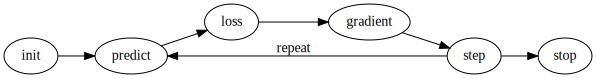

In [125]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

#Simple Logistic Regression

So now we can start doing our implementation. First, we will need to import the libraries.

In [126]:

from fastai2.vision.all import *
matplotlib.rc('image', cmap='Greys')

Then you need to go to the Kaggle website,  download the Kannada-MNIST dataset and unzip it. In the Kannada-MNIST case, we have four files zipped in it.
For this implementation, I am going to be using only 'train.csv'.

In [5]:
!chmod 777 Kannada-MNIST.zip
!unzip Kannada-MNIST.zip

Archive:  Kannada-MNIST.zip
  inflating: Dig-MNIST.csv           
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


The easy way of how you can read the 'train.csv' file is to use pandas function 'read_csv()'. It will read it into pandas DataFrame.
By calling 'head()' on it, we can display the first five rows of its content.
The first column of it is 'label'. It defines what category the row belongs to. 
Each of the other columns represents the pixels from 0 to 784, which is a flattened 28,28 shaped single-channel image.

In [131]:
df = pd.read_csv("train.csv") 
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Then we need to specify a number for random seed. Doing this will let us get the same generated parameters each time we run this notebook.

In [179]:
torch.manual_seed(3)


Here we are converting our data into tuple format (x,y). This is required for PyTorch dataset.
First, we separate the label from all other data into a separate tensor. Then we convert our other data(pixels) into tensor and normalize it by dividing it from 255. this converts our data to be in values between 0 and 1. Finally, we turn it into the tuple.

In [133]:
df_y = tensor(df['label'])
df_x = tensor(df.drop('label', axis=1).values).float() / 255.
df = list(zip(df_x,df_y))

In [134]:
df_y.shape

torch.Size([60000])

Then we split our data into training and validation sets using 'random_split(data, [split_one, split_two)' function.

In [135]:
val_size = int(0.2*len(df))
train_size = len(df) - val_size
train_ds, val_ds = torch.utils.data.random_split(df, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

Now we can start our training process. First, we are going to make a parameter initialization function. It is going to take the wanted matrix shape and deviation range as an input and will return us the initialized matrix. We also call the 'requires_grad_()' function. This tells PyTorch that the created tensor will require gradients.

In [136]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

We are going to have two types of parameters. First is going to be the weights. In this case, you can imagine weights as being values associated with the input. For every pixel in our image(784), we are going to have ten weights, which are going to indicate that pixels importance to each different prediction. All weights will be inside one big matrix representing our one linear layer weights.
The second parameter is going to be bias, 1 per prediction, making it 10 in total.

In [137]:
weights = init_params((28*28,10))
bias = init_params(10)

In [138]:
df_x[0].shape, weights.shape, bias.shape

(torch.Size([784]), torch.Size([784, 10]), torch.Size([10]))


Let us try making a prediction for one image example. For each neuron, we need to multiply each pixel with its weight and sum all of the got values. Then we can add bias.
This gives us one problem. The shape of our pixel tensor is [784], while the shape of our weights is [784, 10]. By transposing our weights matrix, we can get the shape [10,784]. This lets us do element-wise multiplication between two matrices. Python will consider the pixel matrix as being [1,784], and it will broadcast it across all of our weights matrix, giving us a new matrix of shape [10,784].

In [140]:
weights[0]

tensor([-0.1771, -0.6914, -2.0339, -0.0146, -0.0184,  0.0774,  0.1353,  0.0976,
         1.2196,  0.5419], grad_fn=<SelectBackward>)

In [141]:
(df_x[0]*weights.T).shape

torch.Size([10, 784])

Then we can sum all values for each prediction and apply bias.

In [142]:
(df_x[0]*weights.T).sum() + bias

tensor([7.9136, 6.4585, 8.1807, 6.9579, 6.9197, 7.2522, 7.6322, 5.7487, 8.0225,
        6.9266], grad_fn=<AddBackward0>)

Now let's try to make predictions for multiple examples. We could do it as before one image at the time, but python has a nice feature that lets us do matrix multiplication. You need to do everything just like before, but instead of '*' for multiplication, you have to use '@', and we no longer need to Transpose our weights tensor.

In [143]:
def linear(xb): return xb@weights + bias
preds = linear(df_x[:40])
#five predictions
preds[:5]

tensor([[ 1.8791,  2.8753, -1.8936,  8.4709,  0.4792, -8.4212, 13.1066,  4.8924,
         -7.4439, -3.3860],
        [ 1.8609, -7.1370,  5.0990,  2.7264, -2.2692, -3.1977,  1.4100,  0.6469,
         -7.1241, -4.8157],
        [ 5.4444,  5.1601,  3.0672, -6.4859, 11.8515, 14.0330,  4.9745,  0.2390,
          1.2314, -1.5407],
        [-1.0287,  3.9156,  6.9652,  4.6794, -1.9739,  4.1155,  2.4142, -1.3916,
         -4.6344, -1.1138],
        [ 3.6376,  6.2520,  4.0436,  0.5839, -1.3109, -1.8403,  2.0207,  4.5624,
          5.1338,  4.0897]], grad_fn=<SliceBackward>)

Now, when we have our predictions, we can try calculating the accuracy. We are going to take prediction tensor and will find the highest value for each image prediction.

In [144]:
_, example = torch.max(preds, dim=1)
example

tensor([6, 2, 5, 2, 1, 3, 2, 0, 3, 6, 6, 6, 3, 1, 6, 3, 2, 6, 6, 3, 6, 6, 4, 6,
        5, 3, 2, 7, 3, 7, 6, 6, 6, 6, 6, 6, 6, 0, 6, 7])

Then we can take the predicted values and compare it with labels using '==' operation. This will give us a boolean matrix with 'True' in place of correct predictions and 'False' otherwise. 

In [145]:
example == df_y[:40]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, False, False])

By using torch 'sum()' function on it, we can get the total count of 'True' values, and by calling 'item()', we can access it as an integer value.

In [146]:
torch.sum(example == df_y[:40]).item()

2

Then we have to divide it by total count of predictions getting the average of correct predictions value.

In [147]:
torch.tensor(torch.sum(example == df_y[:40]).item() / len(example))

tensor(0.0500)

Lets put everything into one function.

In [148]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [149]:
accuracy(preds, df_y[:40])

tensor(0.0500)

So as we can see, the prediction was terrible. What we want to do is improve our parameters and try calculating again. But how can we do that?
We need to calculate our loss. The accuracy is not a way to calculate it. The reason for that is because accuracy gives us a value that is either right or wrong. We have no idea how wrong or right our prediction was. One way to calculate our loss is to convert our predictions into percentage values representing how likely this output to be the right prediction. So that all of our predictions together would be equal to 1.Thats that we call 'softmax'. By applying log on our calculated 'softmax' we get 'log_softmax' function.

In [150]:
def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)

In [151]:
pred1 = log_softmax(preds)
pred1[0]

tensor([-1.1237e+01, -1.0241e+01, -1.5010e+01, -4.6457e+00, -1.2637e+01,
        -2.1538e+01, -9.9735e-03, -8.2242e+00, -2.0560e+01, -1.6503e+01],
       grad_fn=<SelectBackward>)

Then we are going to select only the value of the correct predictions from all of the samples, calculate their average, and convert it to the positive value. This gives us 'Negative Log-Likelihood'. The bigger value of our output is, the bigger loss we have. The smaller value it is(close to zero), the smaller loss we get.  

In [152]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [153]:
pred1 = log_softmax(preds)
loss1 = nll(pred1, df_y[:40])
loss1

tensor(9.5463, grad_fn=<NegBackward>)

We don't need to implement those two functions by hand. We can use  PyTorch given 'cross_entropy' and get the same result as it is a combination of before implemented 'log_softmax' and 'negative_log_likehood' functions.

In [154]:
loss_fn = F.cross_entropy
# Loss for current batch of data
loss = loss_fn(preds, df_y[:40])
print(loss)

tensor(9.5463, grad_fn=<NllLossBackward>)


So now, then we have our loss its time to run our whole dataset and finally train our network. One thing that we are going to use for our full dataset is DataLoader. It is going to let us train our network using mini-batches.

In [155]:
dl = DataLoader(train_ds, batch_size=256)


If we inspect the size of the first mini-batch, we will notice that it contains 256 images(same size as we defined before).

In [156]:
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256]))

Lets do the same for validation set.

In [157]:
valid_dl = DataLoader(val_ds, batch_size=256)

Now to see if everything is going to work fine, first, let's try to train our network on small dataset example. Let's select 40 examples as before.

In [158]:
batch = df_x[:40]
batch.shape

torch.Size([40, 784])

Run it through the before made linear model and get our calculations.

In [159]:
preds = linear(batch)
preds[:5]

tensor([[ 1.8791,  2.8753, -1.8936,  8.4709,  0.4792, -8.4212, 13.1066,  4.8924,
         -7.4439, -3.3860],
        [ 1.8609, -7.1370,  5.0990,  2.7264, -2.2692, -3.1977,  1.4100,  0.6469,
         -7.1241, -4.8157],
        [ 5.4444,  5.1601,  3.0672, -6.4859, 11.8515, 14.0330,  4.9745,  0.2390,
          1.2314, -1.5407],
        [-1.0287,  3.9156,  6.9652,  4.6794, -1.9739,  4.1155,  2.4142, -1.3916,
         -4.6344, -1.1138],
        [ 3.6376,  6.2520,  4.0436,  0.5839, -1.3109, -1.8403,  2.0207,  4.5624,
          5.1338,  4.0897]], grad_fn=<SliceBackward>)

Calculate our losses.

In [160]:
loss = loss_fn(preds, df_y[:40])
loss

tensor(9.5463, grad_fn=<NllLossBackward>)

It seems that everything works just like before. Now we can start improving our score by optimizing our weights to give us better predictions. We will achieve this with backpropagation. With PyTorch, backpropagation is quite easy. If your parameters had 'requires_grad_()' function called(that we did), PyTorch knows that in case of backpropagation, these values need gradient calculated for them. So you only need to construct the forward pass of your network(what we already did) and call the 'backward()' function after calculating loss. It will make PyTorch calculate the gradients for all of the tensors with 'requires_grad_()' involved with the chain of calculations done calculating the loss.

In [161]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 10]),
 tensor(-1.2164e-10),
 tensor([-0.0235, -0.0493,  0.0064,  0.0444, -0.0689, -0.0630,  0.3313,  0.0054,
         -0.0891, -0.0937]))

Lets put everything into one function.

In [162]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    loss.backward()

Call it again. As you can see while we done the same thing, our gradients increased twice.

In [163]:
calc_grad(batch, df_y[:40], linear)
weights.grad.mean(),bias.grad

(tensor(-2.4328e-10),
 tensor([-0.0471, -0.0987,  0.0127,  0.0889, -0.1379, -0.1260,  0.6627,  0.0108,
         -0.1781, -0.1873]))

By calling 'backward()', we had our parameters gradients saved in 'grad' tensor. After we called 'backward()' again, our gradients had been stacked together with the previous iteration gradients. We want to calculate fresh gradients each time after we finish our training loop. So that we do is call 'zero_()' on our 'grad' tensor. This will do in-place cleaning of our parameter gradient. Note that any Python functions, which have '_' in their name, are usually doing in-place editing.

In [164]:
weights.grad.zero_()
bias.grad.zero_();

So now, we mostly did everything that you need to train our neural network apart from updating the weights with the calculated gradient.

Let's Initialize our parameters from the start and do everything in one function.

In [165]:
weights = init_params((28*28,10))
bias = init_params(10)

'Train_epoch' basically contains our training loop. It runs our batches through a linear layer and calculates the loss and gradients. Finally, updates our parameters accordingly to it using the learning rate.

In [166]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [167]:
lr = .5
params = weights,bias
train_epoch(linear, lr, params)

That's it! We just trained our linear layer for one epoch. Let's define our function for testing on the validation set. It will iterate through our mini-batches in the validation DataLoader, will calculate their accuracy using before defined 'accuracy' function. And will return us the average loss of our mini-batches.

In [168]:
def validate_epoch(model):
    accs = [accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 6)

After 1 loop we got 83%. Thats not bad.

In [169]:
validate_epoch(linear)

0.838217

After iterating for another 20 times we have reached the accuracy of 95%. 

In [170]:
for i in range(20):
    train_epoch(linear, lr, params)
    print(validate_epoch(linear), end=' ')

0.882017 0.902106 0.913184 0.920272 0.925936 0.930044 0.933463 0.936455 0.938521 0.941098 0.94276 0.94409 0.945681 0.947343 0.948506 0.949254 0.949836 0.950917 0.951487 0.952401 

Thats it! Thats the implementation of the logistic regression!

#Creating an Optimizer

Now, let's rewrite this in an easier way using PyTorch.
 
First of all, PyTorch has a linear layer implementation.

In [180]:
linear_model = nn.Linear(28*28,10)

By using PyTorch layers, we no longer need to initialize parameters. PyTorch does it for us simply by looking at the specified shape for the required layer and creating parameters for it. By calling 'parameters()' function on our created layers, we can inspect the created parameters.

In [172]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

Let's define an optimizer class. That optimizer will do it will contain the functions for adjusting our parameters data after PyTorch calculates the gradients. 

In [173]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

To initialize it, you need to give it a parameters of your layer and a learning rate.

In [185]:
opt = BasicOptim(linear_model.parameters(), lr)

As you can see, this is our updated training loop. It looks very much the same as the one we had before, with a difference that we have our parameters updating in a 'step()' function.

In [181]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Initial value with no training.

In [187]:
validate_epoch(linear_model)

0.966304

Lets put Everything into one function.

In [183]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

As you can see, we get very similar results as before. The only difference is that I have not reset the random seed before doing layer initialization, getting different random parameters.

In [186]:
train_model(linear_model, 20)

0.950311 0.954906 0.957471 0.959477 0.960558 0.961472 0.961638 0.962054 0.962802 0.963395 0.963645 0.964143 0.964309 0.964725 0.965141 0.96539 0.965639 0.965972 0.966138 0.966304 

So now, let's make everything even more abstract. Before, we have created our optimizer class. Instead, we could have used PyTorch given SGD(Stochastic Gradient Descent) optimizer.

In [188]:
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.948803 0.954134 0.957803 0.958812 0.960225 0.960724 0.961555 0.962149 0.96298 0.963395 0.963645 0.963977 0.964309 0.964642 0.965057 0.965224 0.965473 0.965722 0.966304 0.966637 

We can make this even more abstract using fastai library. For fastai we need to use DataLoaders.

In [189]:
dls = DataLoaders(dl, valid_dl)

Then we define our learner. It contains everything needed for our training loop:

1.   DataLoaders containing our training and validation sets.
2.   Model construction containing our neural network layers.
3.   Optimization method.
4.   Loss function.
5.   Metric used for evaluation



In [190]:
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=loss_fn, metrics=accuracy)

Now we can call fit and train our neural network for the specified amount of epochs using the selected learning rate.

In [191]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.246657,0.211038,0.948667,00:01
1,0.182390,0.174122,0.954083,00:01
2,0.161337,0.158016,0.957750,00:01
3,0.149650,0.148503,0.959500,00:01
4,0.141770,0.142068,0.960167,00:01
5,0.135925,0.137359,0.961000,00:01
6,0.131332,0.133732,0.961667,00:01
7,0.127578,0.130832,0.961917,00:01
8,0.124423,0.128451,0.962667,00:01
9,0.121715,0.126453,0.963083,00:01


#Adding a Nonlinearity

So just now, we have created a very simple one layer linear model. Now we are going to convert it into the neural network, which contains two layers. To do that, we need to specify the relu layer in between two linear layers. Relu stands for a rectified linear unit. Also, known as... a very simple function with a fancy name? That relu does it simply takes all negative values and converts it to zero. We need to do this because we can not stack multiple linear layers, one on another directly. If we do that, it's no different from having another big linear layer with more parameters.

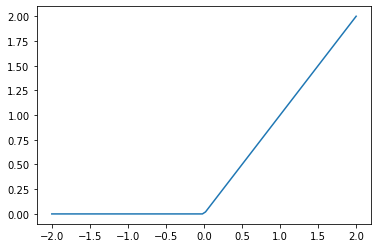

In [192]:
x = torch.linspace(-2,2)
plt.plot(x,F.relu(x))

Let's create our new model structure. Before then, we had only one linear layer, our input and output size for one layer was ('784,10'). That was because we had 784 pixels as input and 10 classes as output. Now when we have two linear layers, we need to do it differently. The input size of the first layer will be the same as before ('784'), but the output will be different. That is because now we don't output the answer directly, but we output our one layer calculations, to be used as an input to the second layer ( after applying relu).
So first layer output and second layer input have to be the same size(we are going to select 30). And the second layer output will be 10(just like the output of the model that we had before, which used a single layer). 

To create this kind of model with PyTorch is very easy.

In [205]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)

Lets again use learners with the same parameters as before. The only different thing is our model.

In [206]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=loss_fn, metrics=accuracy)

In [207]:
#hide_output
learn.fit(20, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.189856,0.147509,0.958333,00:01
1,0.130752,0.122994,0.963833,00:01
2,0.112055,0.111091,0.967417,00:01
3,0.099534,0.102761,0.970000,00:01
4,0.089759,0.096738,0.971500,00:01
5,0.081751,0.092475,0.973000,00:01
6,0.075043,0.088797,0.974833,00:01
7,0.069271,0.085902,0.975667,00:01
8,0.064231,0.083595,0.976583,00:01
9,0.059664,0.081601,0.977250,00:01


As you can see the accuracy increased to 98%.

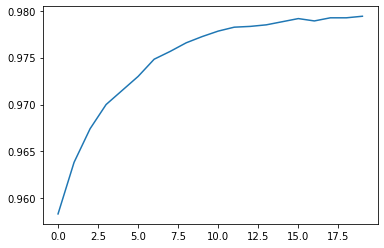

In [209]:
plt.plot(L(learn.recorder.values).itemgot(2));

Thats it. Thank you very for reading!!!

In [212]:
!jupyter_to_medium --pub-name="Logistic Regression with Kannada-MNIST" --tags="python, data science, fastai" "Logistic Regression with Kannada-MNIST.ipynb"

Traceback (most recent call last):
  File "/usr/local/bin/jupyter_to_medium", line 5, in <module>
    from jupyter_to_medium._command_line import main
  File "/usr/local/lib/python3.6/dist-packages/jupyter_to_medium/__init__.py", line 1, in <module>
    from ._publish_to_medium import publish
  File "/usr/local/lib/python3.6/dist-packages/jupyter_to_medium/_publish_to_medium.py", line 10, in <module>
    from ._preprocesors import MarkdownPreprocessor, NoExecuteDataFramePreprocessor
  File "/usr/local/lib/python3.6/dist-packages/jupyter_to_medium/_preprocesors.py", line 102, in <module>
    ss_creator = make_repr_png()
  File "/usr/local/lib/python3.6/dist-packages/jupyter_to_medium/_screenshot.py", line 196, in make_repr_png
    ss = Screenshot(max_rows, max_cols, ss_width, ss_height, resize, chrome_path)
  File "/usr/local/lib/python3.6/dist-packages/jupyter_to_medium/_screenshot.py", line 74, in __init__
    self.chrome_path = get_chrome_path(chrome_path)
  File "/usr/local/lib/pyth